In [ ]:
#Guassian Kernel Density Estimation

In [ ]:
#Figure 3

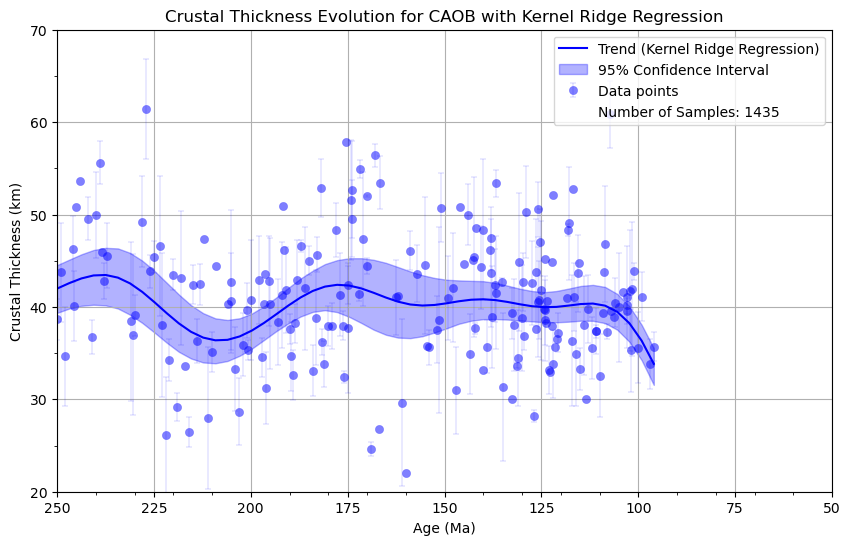

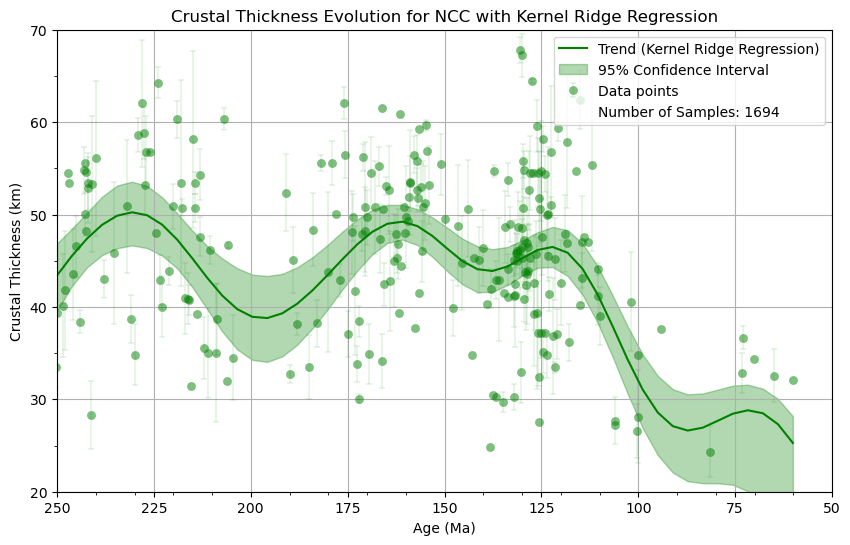

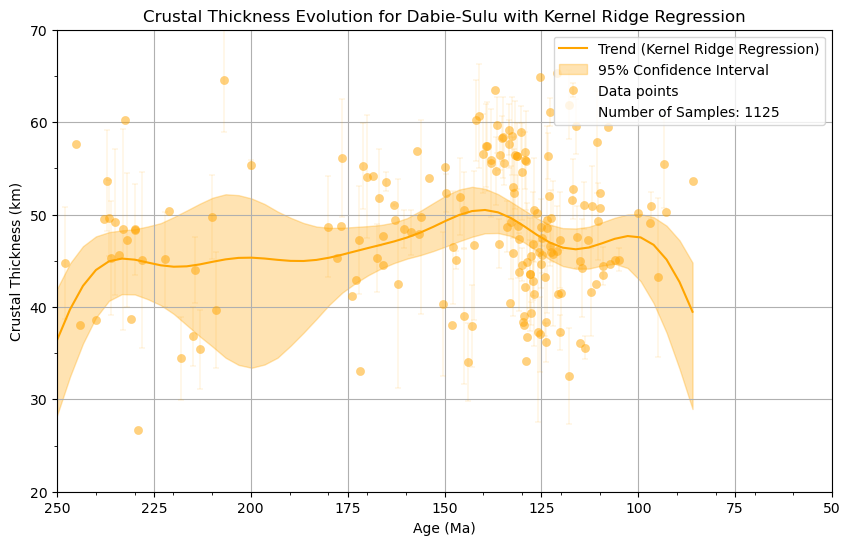

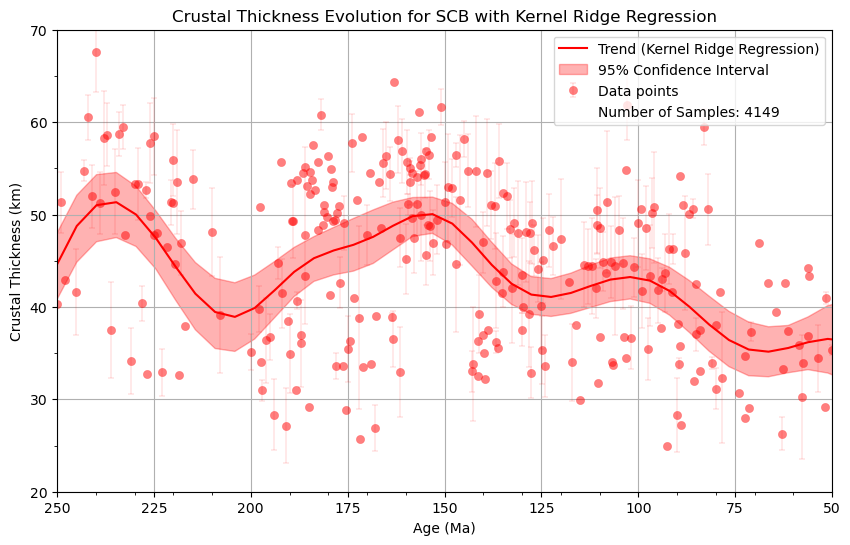

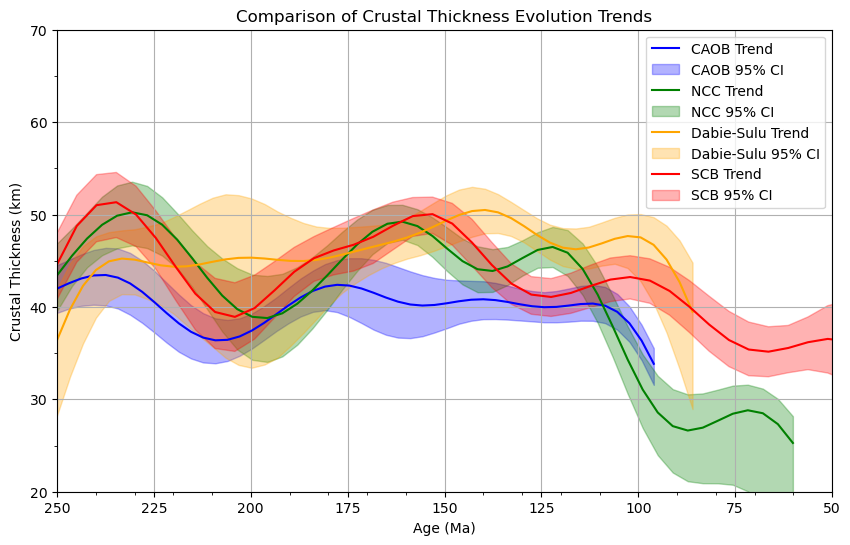

In [1]:
import pandas as pd
import numpy as np
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge

# List of file paths
file_paths = [
    "/Users/jianpingzhou/work/Papers/Andean-type/data/01_E_CAOB.csv",
    "/Users/jianpingzhou/work/Papers/Andean-type/data/02_ENCC.csv",
    "/Users/jianpingzhou/work/Papers/Andean-type/data/03_Dabie_Sulu.csv",
    "/Users/jianpingzhou/work/Papers/Andean-type/data/04_South China+SK.csv"
]

# Colors for each dataset
colors = ['blue', 'green', 'orange','red']
labels = ['CAOB', 'NCC', 'Dabie-Sulu','SCB']

# Initialize a list to store data for comparison plot
all_age_ranges = []
all_predicted_thicknesses = []
all_ci_lowers = []
all_ci_uppers = []

for idx, file_path in enumerate(file_paths):
    # Read each CSV dataset
    df = pd.read_csv(file_path)

    # Group by Age, Latitude, and Longitude and calculate median and standard deviation of crustal thickness
    grouped = df.groupby(['Age', 'Lat', 'Lon'])['Predicted_Crustal_Thickness'].agg(['median', 'std']).reset_index()
    grouped.rename(columns={'median': 'Median_Crustal_Thickness', 'std': 'Error'}, inplace=True)

    # Merge the grouped data back with the original dataframe to map the median and error values
    df = df.merge(grouped, on=['Age', 'Lat', 'Lon'], how='left')

    # Group by Age to compute the median crustal thickness and error bars
    grouped_age = df.groupby('Age').agg({'Median_Crustal_Thickness': 'median', 'Error': 'mean', 'Age error': 'mean'}).reset_index()
    grouped_age.rename(columns={'Median_Crustal_Thickness': 'Crustal_Thickness_Median', 'Error': 'Crustal_Thickness_Error', 'Age error': 'Age_Error'}, inplace=True)

    # Extract columns for plotting
    age = grouped_age['Age']
    crustal_thickness_median = grouped_age['Crustal_Thickness_Median']
    crustal_thickness_error = grouped_age['Crustal_Thickness_Error']

    # Plot the correlation between crustal thickness (median) and age with error bars
    plt.figure(figsize=(10, 6))
    plt.errorbar(age, crustal_thickness_median, yerr=crustal_thickness_error, fmt='o', color=colors[idx], ecolor=colors[idx], alpha=0.5, elinewidth=0.25, capsize=2.5, markeredgewidth=0.25, label='Data points')
    plt.xlabel('Age (Ma)')
    plt.ylabel('Crustal Thickness (km)')
    plt.title(f'Crustal Thickness Evolution for {labels[idx]} with Error Bars')

    # Add second tick marks
    ax = plt.gca()
    ax.xaxis.set_minor_locator(MultipleLocator(10))
    ax.yaxis.set_minor_locator(MultipleLocator(5))
    plt.grid(True)

    # Kernel Ridge Regression
    bandwidth = 18.0  # Example desired bandwidth
    gamma = 1 / (2 * bandwidth ** 2)
    kr = KernelRidge(kernel='rbf', alpha=1.0, gamma=gamma)

    # Fit the Kernel Ridge model to the data
    age_reshaped = age.values.reshape(-1, 1)
    kr.fit(age_reshaped, crustal_thickness_median)

    # Create a range of age values for prediction
    age_range = np.linspace(age.min(), 250).reshape(-1, 1)

    # Perform predictions with the Kernel Ridge model
    predicted_thickness = kr.predict(age_range)

    # Bootstrap resampling for confidence intervals
    bootstrap_samples = 10000
    bootstrap_predictions = np.zeros((bootstrap_samples, age_range.shape[0]))

    for i in range(bootstrap_samples):
        resample_idx = np.random.choice(len(age), len(age), replace=True)
        kr.fit(age_reshaped[resample_idx], crustal_thickness_median.values[resample_idx])
        bootstrap_predictions[i, :] = kr.predict(age_range)

    # Calculate the 95% confidence interval
    ci_lower = np.percentile(bootstrap_predictions, 2.5, axis=0)
    ci_upper = np.percentile(bootstrap_predictions, 97.5, axis=0)

    # Store data for the final comparison plot
    all_age_ranges.append(age_range)
    all_predicted_thicknesses.append(predicted_thickness)
    all_ci_lowers.append(ci_lower)
    all_ci_uppers.append(ci_upper)

    # Plot the Kernel Ridge Regression trend line with confidence intervals for each dataset
    plt.plot(age_range, predicted_thickness, color=colors[idx], label='Trend (Kernel Ridge Regression)')
    plt.fill_between(age_range.flatten(), ci_lower, ci_upper, color=colors[idx], alpha=0.3, label='95% Confidence Interval')

    # Set plot limits and labels
    plt.xlim(250, 50)
    plt.ylim(20, 70)
    plt.xlabel('Age (Ma)')
    plt.ylabel('Crustal Thickness (km)')
    plt.title(f'Crustal Thickness Evolution for {labels[idx]} with Kernel Ridge Regression')

    # Add number of samples to the legend
    num_samples = len(df)
    handles, labels_plot = plt.gca().get_legend_handles_labels()
    handles.append(plt.Line2D([], [], color='none', label=f'Number of Samples: {num_samples}'))
    plt.legend(handles=handles, loc='upper right')

    # Add second tick marks
    ax = plt.gca()
    ax.xaxis.set_minor_locator(MultipleLocator(10))
    ax.yaxis.set_minor_locator(MultipleLocator(5))
    plt.grid(True)

    # Save the individual plot to a PDF file
    plt.savefig(f"/Users/jianpingzhou/work/Papers/Andean-type/data/test/{labels[idx]}_crustal_thickness_vs_age.pdf", format='pdf', dpi=300, bbox_inches='tight')
    plt.show()

# Create a combined plot to compare all trends
plt.figure(figsize=(10, 6))

for idx, label in enumerate(labels):
    plt.plot(all_age_ranges[idx], all_predicted_thicknesses[idx], color=colors[idx], label=f'{label} Trend')
    plt.fill_between(all_age_ranges[idx].flatten(), all_ci_lowers[idx], all_ci_uppers[idx], color=colors[idx], alpha=0.3, label=f'{label} 95% CI')

# Set plot limits and labels
plt.xlim(250, 50)
plt.ylim(20, 70)
plt.xlabel('Age (Ma)')
plt.ylabel('Crustal Thickness (km)')
plt.title('Comparison of Crustal Thickness Evolution Trends')

# Add legend
plt.legend(loc='upper right')

# Add second tick marks
ax = plt.gca()
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(5))
plt.grid(True)

# Save the comparison plot to a PDF file
plt.savefig("/Users/jianpingzhou/work/Papers/Andean-type/data/test/comparison_crustal_thickness_vs_age.pdf", format='pdf', dpi=300, bbox_inches='tight')

# Show the comparison plot
plt.show()
